In [2]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [3]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Read the training and test dataset

In [5]:
train= pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [6]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Stack the training and test datasets into a single one

In [7]:
full = pd.concat([train, test],axis=0,sort=False)

### Which columns have non-numeric values and need encoding?

In [8]:
train.select_dtypes(exclude=[np.number]).head()

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
0,P00069042,F,0-17,A,2
1,P00248942,F,0-17,A,2
2,P00087842,F,0-17,A,2
3,P00085442,F,0-17,A,2
4,P00285442,M,55+,C,4+


In [9]:
train_shape = train.shape
test_shape = test.shape

In [10]:
del train
del test

### Transform the Age column by mapping it to the mean of the range

In [11]:
print(full.Age.value_counts())
age_transform = {'26-35':(26+35)/2, '36-45':(36+45)/2, '18-25':(18+25)/2, '46-50':(46+50)/2, '51-55':(51+55)/2, '0-17':17/2, '55+':60}
full['Age'] = full['Age'].apply(lambda x: age_transform[x])

26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Age, dtype: int64


In [12]:
#train['Product_ID'] = train['Product_ID'].apply(lambda x: x[1:]).apply(int)

In [13]:
full.select_dtypes(exclude=[np.number]).head()

,Product_ID,Gender,City_Category,Stay_In_Current_City_Years
0,P00069042,F,A,2
1,P00248942,F,A,2
2,P00087842,F,A,2
3,P00085442,F,A,2
4,P00285442,M,C,4+


In [14]:
full.Stay_In_Current_City_Years.value_counts()

1     276425
2     145427
3     135428
4+    120671
0     105716
Name: Stay_In_Current_City_Years, dtype: int64

In [15]:
full.loc[full.Stay_In_Current_City_Years == '4+', 'Stay_In_Current_City_Years'] = '4'
full['Stay_In_Current_City_Years'] = full['Stay_In_Current_City_Years'].astype('int')

### One-hot encode the `Gender` and `City_Category` features

In [16]:
df_dummy_gender = pd.get_dummies(full['Gender'],prefix = 'Gender')
df_dummy_city_cat = pd.get_dummies(full['City_Category'],prefix = 'City_Category')

In [17]:
full = pd.concat([full, df_dummy_gender,df_dummy_city_cat], axis=1)

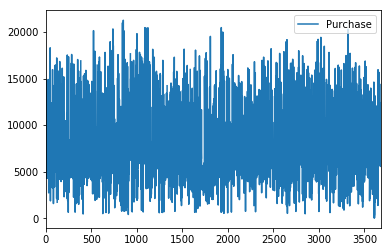

In [18]:
full.groupby('Product_ID').mean().reset_index()[['Product_ID','Purchase']].plot()

## Feature engineering

In [19]:
## Encode the Product ID's using standard Encoder
enc = sklearn.preprocessing.LabelEncoder()
full['Product_ID'] = enc.fit_transform(full['Product_ID'])  

#### Create a new feature based on the average purchase price per product.  This turns out to be an important feature.
Some Product ID's in the training set are new. For these rows, the average purchase price of all the products will be used.

In [20]:
dict_avg_purchase = {}
avg_purchase_price = full['Purchase'].mean()
for index,row in full.groupby('Product_ID').mean().reset_index()[['Product_ID','Purchase']].iterrows():
    dict_avg_purchase[row['Product_ID']] = row['Purchase']
full['avg_product_price'] = full['Product_ID'].apply(lambda x: dict_avg_purchase[x] if x in dict_avg_purchase.keys() else avg_purchase_price)
full.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender_F,Gender_M,City_Category_A,City_Category_B,City_Category_C,avg_product_price
0,1000001,684,F,8.5,10,A,2,0,3,NaN,NaN,8370.0,1,0,1,0,0,11870.863436
1,1000001,2406,F,8.5,10,A,2,0,1,6.0,14.0,15200.0,1,0,1,0,0,16304.030981
2,1000001,868,F,8.5,10,A,2,0,12,NaN,NaN,1422.0,1,0,1,0,0,1237.892157
3,1000001,844,F,8.5,10,A,2,0,12,14.0,NaN,1057.0,1,0,1,0,0,1455.140762
4,1000002,2769,M,60.0,16,C,4,0,8,NaN,NaN,7969.0,0,1,0,0,1,7692.763547


### Which columns have `NA` values?

In [21]:
full.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            245982
Product_Category_3            545809
Purchase                      233599
Gender_F                           0
Gender_M                           0
City_Category_A                    0
City_Category_B                    0
City_Category_C                    0
avg_product_price                 61
dtype: int64

In [22]:
#full['Purchase'].mean() == full['Purchase'].iloc[:train_shape[0]].mean()

 Fill the missing `avg_product_price` values with the mean purchase price of that product

In [23]:
full['avg_product_price'].fillna(avg_purchase_price, inplace = True)

Drop the Gender and City category columns since they have already been encoded

In [24]:
full = full.drop(['Gender','City_Category'], axis=1)

#### Create new features bases on the counts of User IDs ,Product IDs, Age, Occupation and Product_Category_1

In [25]:
def get_counts(df, parameter,newcolname=None):
    newdict = {}
    if not newcolname:
        newcolname = "count_"+parameter
    grouping = df.groupby(parameter)
    for key, val in grouping:
        newdict[key] = val.size
    df[newcolname] = df[parameter].apply(lambda x: newdict[x])/df.size ##normalized counts
    return df

In [26]:
count_features = ['User_ID', 'Product_ID', 'Age', 'Occupation','Product_Category_1']
for feature in count_features:
    full = get_counts(full, feature)

In [27]:
#plt.style.use('fivethirtyeight')
#plt.figure(figsize = (10,8))
#sns.heatmap( train.corr())
#full.corr()

In [28]:
#df_user= train.groupby('User_ID')['Product_ID'].count().reset_index()
#df_user.columns = ['User_ID', 'num_purchases']
#train = pd.merge(train, df_user , on = 'User_ID')


Replace NA values in `Product_Category_2` and `Product_Category_3`

In [29]:
full['Product_Category_2'].fillna(-999,inplace = True)

In [30]:
full['Product_Category_3'].fillna(-999,inplace = True)

Divide dataset into train and test as in the original data. Pre-processing is complete at this stage.

In [31]:
train = full.iloc[:train_shape[0],:]
test = full.iloc[train_shape[0]:,:]
print(train.shape)
print(test.shape)
#train.drop(['Purchase'], axis =1, inplace = True)

(550068, 21)
(233599, 21)


In [32]:
target = train['Purchase']

In [33]:
train.drop(['Purchase'], axis =1, inplace = True)

/Users/debashis/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
test.drop(['Purchase'], axis =1, inplace = True)

### Generate train and test splits by masking

In [35]:
X=train.values
y=target.values
itrain, itest = train_test_split(range(train.shape[0]), test_size=0.3,random_state = 42)
mask=np.ones(train.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

In [36]:
def grid_search(clf, parameters, X, y, n_jobs=1, n_folds=3, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best


def do_regression(model,  Xtrain, ytrain, Xtest, ytest, parameters, n_folds=3, n_jobs=1):
    if parameters:
        model = grid_search(model, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds)
    model=model.fit(Xtrain, ytrain)
    training_score = model.score(Xtrain, ytrain)
    test_score = model.score(Xtest, ytest)
    print ("############# based on standard predict ################")
    print ("coefficient of determination R^2 on training data: %0.2f" % (training_score))
    print ("coefficient of determination R^2 on test data:     %0.2f" % (test_score))
    print ("########################################################")
    return model, Xtrain, ytrain, Xtest, ytest



## ML models
First we will try Random Forests regressor model. All cross-validation studies can be found towards the end of this notebook.

In [52]:

rfmodel = RandomForestRegressor(n_estimators = 700, max_features = 10, max_depth=None, 
                                n_jobs= -1, min_samples_split=10, min_samples_leaf = 3, 
                                random_state=123, verbose =1)
parameters = {'n_estimators': [300,500,700], 'max_features': range(5,8)}
rfmodel, Xtrain, ytrain, Xtest, ytest = do_regression(rfmodel, Xtrain, ytrain, 
                                                      Xtest, ytest, parameters = None, n_folds =3,
                                                     n_jobs = -1) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  8.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   15.8s


############# based on standard predict ################
coefficient of determination R^2 on training data: 0.88
coefficient of determination R^2 on test data:     0.74
########################################################


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   23.6s finished


In [53]:
rf_predict_train = rfmodel.predict(Xtrain)
print("RMSE = ", np.sqrt(mean_squared_error(ytrain, rf_predict_train)) )

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.9s


RMSE =  1758.7395555571923


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   57.4s finished


In [54]:
rf_predict_test = rfmodel.predict(Xtest)
print("RMSE = ", np.sqrt(mean_squared_error(ytest, rf_predict_test)) )

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   16.2s


RMSE =  2565.4171970100156


[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   24.6s finished


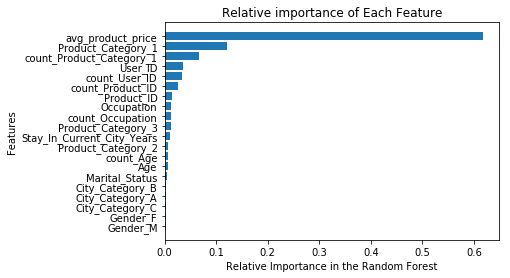

In [55]:
importance_list = rfmodel.feature_importances_
name_list = train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Extremely Randomized trees

In [40]:
etmodel = ExtraTreesRegressor(n_estimators=500, max_features='auto',max_depth=10,
                             min_samples_split=6, 
                              min_samples_leaf=2,
                             verbose=1, n_jobs=4,random_state=123)
etmodel.fit(Xtrain, ytrain)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  9.1min finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=2, min_samples_split=6,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
          oob_score=False, random_state=123, verbose=1, warm_start=False)

In [41]:
et_predict_test = etmodel.predict(Xtest)
print("RMSE = ", np.sqrt(mean_squared_error(ytest, et_predict_test)) )

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s


RMSE =  2648.064502098684


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.3s finished


In [42]:
et_predict_train = etmodel.predict(Xtrain)
print("RMSE on training set = ", np.sqrt(mean_squared_error(ytrain, et_predict_train)) )

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.8s


RMSE on training set =  2606.9755643375197


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.6s finished


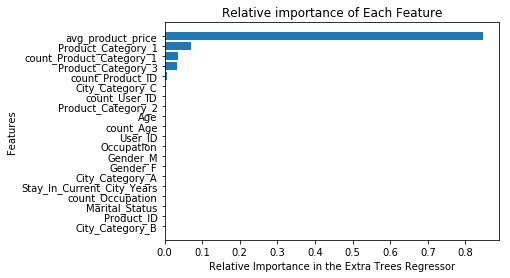

In [43]:
importance_list = etmodel.feature_importances_
name_list = train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Extra Trees Regressor')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

## XgBoost

Now let's train the model with XGBoost. The hyperparameters were tuned via Grid Search and Cross validation techniques which can be found towards the end of the notebook. Here the best parameters have been selected for training.

In [47]:
dtrain = xgb.DMatrix(pd.DataFrame(Xtrain,columns=list(train.columns)), label=pd.DataFrame(ytrain, columns=['Purchase']))
dtest = xgb.DMatrix(pd.DataFrame(Xtest,columns=list(train.columns)))

In [89]:
param = {}
param['eta'] = 0.3
param['gamma'] = 0.05 #1
param['verbosity'] = 1
#param['min_child_weight'] = 5
#param['colsample_bynode'] = 0.9
param['colsample_bytree'] = 0.8
#param['subsample'] = 0.9
param['lambda']= 1.6
param['max_depth'] = 8

num_boost_round = 250
bst = xgb.train(params=param, dtrain=dtrain,num_boost_round=num_boost_round)

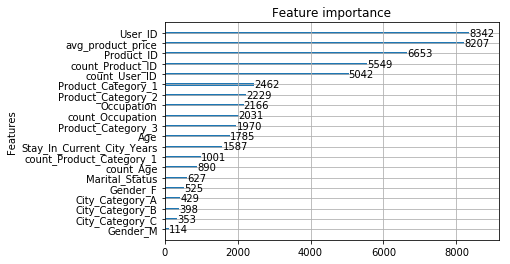

In [90]:
xgb.plot_importance(bst, xlabel=None)

In [91]:
pred_xgboost_dtrain =  bst.predict(dtrain)
pred_xgboost_dtest = bst.predict(dtest)

In [92]:
print("RMSE on test set = ", np.sqrt(mean_squared_error(ytest, pred_xgboost_dtest)) )
print("RMSE of training set = ", np.sqrt(mean_squared_error(ytrain, pred_xgboost_dtrain)) )

RMSE on test set =  2488.0694134191726
RMSE of training set =  2087.979548230976


## stacked model

In [56]:
stack_train = np.hstack((Xtrain,pred_xgboost_dtrain[:,np.newaxis],
                         rf_predict_train[:,np.newaxis], et_predict_train[:,np.newaxis] ))

stack_test = np.hstack((Xtest,pred_xgboost_dtest[:,np.newaxis], 
                        rf_predict_test[:,np.newaxis], et_predict_test[:,np.newaxis]))

In [57]:
stack_list_cols = list(train.columns)
stack_list_cols.extend(['xgb_pred', 'rf_pred', 'et_pred'])
#stack_list_cols

In [62]:
param = {}
param['eta'] = 0.3
param['gamma'] = 1
param['verbosity'] = 1
#param['min_child_weight'] = 5
param['colsample_bytree'] = 0.6
param['colsample_bylevel'] = 0.7
param['subsample'] = 0.7
param['lambda']= 1.6
param['max_depth'] = 6
num_boost_round = 200 
### To control overfitting additional parameters are tuned above
## With the single model parameter set, I was getting
#RMSE of test set =  2730.239745788226
#RMSE of training set =  746.1611894630665
dtrain_stack = xgb.DMatrix(pd.DataFrame(stack_train,columns=stack_list_cols), label=pd.DataFrame(ytrain, columns=['Purchase']))
bst_stack = xgb.train(param, dtrain_stack,num_boost_round)

In [63]:
dtest_stack = xgb.DMatrix(pd.DataFrame(stack_test,columns=stack_list_cols))
pred_xgboost_stack = bst_stack.predict(dtest_stack)
print("RMSE of test set = ", np.sqrt(mean_squared_error(ytest, pred_xgboost_stack)) )
print("RMSE of training set = ", np.sqrt(mean_squared_error(ytrain, bst_stack.predict(dtrain_stack))) )

RMSE of test set =  2688.510627599515
RMSE of training set =  913.5919070222776


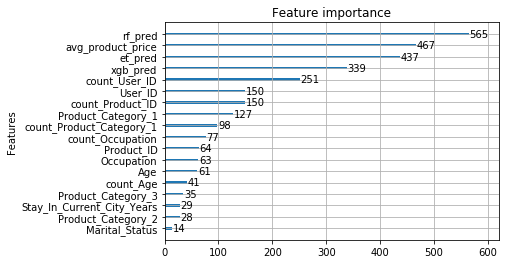

In [371]:
xgb.plot_importance(bst_stack, xlabel=None)

## Predictions on the test set

In [81]:
ctest = test.copy()
dtest_final = xgb.DMatrix(ctest)
pred_xgboost_final = bst.predict(dtest_final)

In [580]:
#rf_predict_testfinal = rfmodel.predict(ctest)
#et_predict_testfinal = etmodel.predict(ctest)

In [382]:
#ctest['xgb_pred'] = pred_xgboost_final
#ctest['rf_pred'] = rf_predict_testfinal
#ctest['et_pred'] = et_predict_testfinal
#dtest_stack_final = xgb.DMatrix(ctest)
#pred_xgboost_stack_final = bst_stack.predict(dtest_stack_final)

In [82]:
submission = pd.read_csv("./Sample_Submission_Tm9Lura.csv") 

In [83]:
#submission['Purchase'] = pred_xgboost_stack_final
#submission['Purchase'] = pred_xgboost_final
#submission['Purchase'] = (pred_xgboost_final + rfmodel.predict(test) + etmodel.predict(test))/3
submission['User_ID'] = ctest.User_ID
submission['Product_ID'] = enc.inverse_transform(ctest['Product_ID'])

In [84]:
submission.to_csv('solution.csv',index = False,header=True)

# Cross validation

### Random forest model

Doing grid search with random forests was way too computationally intensive for my system (Macbook pro, 8GB RAM). So I have presented the cross validation scores below after hand-picking the hyperparameters.

In [609]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfmodel, Xtrain, ytrain, cv=4,  scoring='neg_mean_squared_error')
#print("Score: %0.2f (+/- %0.2f)" % (scores./mean(), scores.std() * 2))
print(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  6.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n

[-6643100.80080158 -6653583.82190299 -6590207.02740985 -6620647.39123169]


In [611]:
print(np.sqrt(np.abs(scores)))

[2577.42134716 2579.45417131 2567.1398535  2573.06187085]


### Extra Trees model

In [ ]:
kf = KFold(n_splits=4, random_state=123, shuffle=True)
for train_index, validation_index in kf.split(train):    
    train_X, validation_X = train.iloc[train_index, :], train.iloc[validation_index, :]
    train_y, validation_y = target[train_index], target[validation_index]
    model_cv_et = etmodel.fit(train_X, train_y)
    model_cv_predict = etmodel.predict(validation_X)
    print (np.sqrt(mean_squared_error(validation_y, model_cv_predict)))

In [ ]:
from sklearn.model_selection import cross_val_score
et_scores = cross_val_score(estimator=etmodel, X=train, y=target, cv=4, scoring='neg_mean_squared_error')  
print(np.sqrt(np.abs(et_scores)))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 10.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.4min finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    8.0s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   20.0s
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:   22.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   58.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 33.9min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 203.7min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 292.3min finished
[Parallel

### XGBoost Grid search

In [44]:
## Grid search with cross validation ##############

gbm_param_grid = {
#    'colsample_bytree': [0.6,0.8],
    'colsample_bytree': [0.8],
#    'colsample_bynode':  [0.9,1],
#    'reg_lambda': [1,1.2,1.4,2],
    'reg_lambda': [1.6],
    'max_depth': [5,7,8],
#        'max_depth': [8],
#    'learning_rate': [0.1,0.3, 0.5]
    'learning_rate': [0.3],
#    'subsample': [0.6,0.8,0.9,1]
    'subsample': [1],
#    'gamma':[0.1,0.3,0.5, 1,1.2,1.5]
        'gamma':[0.05],
#    'min_child_weight':[1,3,5]
    'min_child_weight':[1]
}

gbm = xgb.XGBRegressor(n_estimators=100, n_jobs=3, random_state=123)

# Perform grid search
grid_xgb = GridSearchCV(param_grid=gbm_param_grid, estimator=gbm, cv=4,verbose=2, 
                        n_jobs=4, scoring='neg_mean_squared_error')
# Fit to the data
grid_xgb.fit(Xtrain,ytrain)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 22.0min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=3,
       nthread=None, objective='reg:linear', random_state=123, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'colsample_bytree': [0.8], 'reg_lambda': [1.6], 'max_depth': [5, 7, 8], 'learning_rate': [0.1, 0.3], 'subsample': [1], 'gamma': [0.05], 'min_child_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [45]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_xgb.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_xgb.best_score_)))

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 1, 'reg_lambda': 1.6, 'subsample': 1}
Lowest RMSE found:  2500.32950744799


In [223]:
dfull_train = xgb.DMatrix(train,label=target)

/Users/debashis/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/debashis/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [229]:
param = {}
param['eta'] = 0.1
#param['verbosity'] = 1
param['colsample_bytree'] = 0.6
param['subsample'] = 0.7
param['lambda']= 1.5
param['max_depth'] = 5

cv_xgb = xgb.cv(param, dfull_train, num_boost_round=100, metrics = 'rmse',
           nfold=5,  early_stopping_rounds=10)
cv_xgb['test-rmse-mean'].iloc[-1]

## Stacked model

In [210]:
cv_xgb_stack = xgb.cv(param, dtrain_stack, num_boost_round=100, metrics = 'rmse',
           nfold=4,  early_stopping_rounds=10)

In [222]:
cv_xgb_stack['test-rmse-mean'].iloc[-1]

1067.5854494

In [171]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)
param = {}
param['eta'] = 0.05
param['gamma'] = 2
param['verbosity'] = 1
#param['min_child_weight'] = 5
param['colsample_bytree'] = 0.7
param['colsample_bylevel'] = 0.7
param['subsample'] = 0.7
param['lambda']= 2
param['max_depth'] = 4
num_boost_round = 200 

for train_index, validation_index in kf.split(stack_train):
    
    train_X, validation_X = stack_train[train_index, :], stack_train[validation_index, :]
    train_y, validation_y = ytrain[train_index], ytrain[validation_index]
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model_cv_xgboost = xgb.train(param, xgtrain, num_boost_round)
    model_cv_predict = model_cv_xgboost.predict(xgb.DMatrix(validation_X))
    print (np.sqrt(mean_squared_error(validation_y, model_cv_predict)))

In [486]:
full.size

12538672